In [1]:
!pip install --upgrade statsmodels  dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.1 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.11.2
    Uninstalling dask-2024.11.2:
      Successfully uninstalled dask-2024.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2024.11.2 requires dask==2024.11.2, but you have dask 2025.2.0 which is incompatible.
dask-expr 1.1.19 requires dask==2024.11.2, but you have dask 2025.2.0 which is incompatible.
rapids-dask-dependency 24.12.0 requires dask==2024.11.2, but you have dask 2025.2.0 which is incompatible.


### Importing libraries

In [2]:
import pandas as pd
import dask.dataframe as dd
from enum import unique
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

### Connecting to googledrive

In [3]:
# connecting to googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading the data

In [4]:
ruta = '/content/drive/MyDrive/postulaciones/celes_test/data_challenge.parquet'
df = dd.read_parquet(ruta, parse_dates=["Date"],
                     engine = 'pyarrow'
                 )

# Sort by Date to maintain time series order
df = df.sort_values("Date").persist()

### Type of variable and usage memory

In [5]:
def dask_info(df):
    print("Dask DataFrame Info")
    print("-" * 40)
    print(f"Number of partitions: {df.npartitions}")
    print("\nColumn Information:")
    print(df.dtypes)
    print("\nMemory Usage:")
    print(df.memory_usage(deep=True).compute())

dask_info(df)


Dask DataFrame Info
----------------------------------------
Number of partitions: 1

Column Information:
Date           string[pyarrow]
ProductID      string[pyarrow]
StoreID        string[pyarrow]
ProductName    string[pyarrow]
Quantity               float64
Price                  float64
dtype: object

Memory Usage:
Index           336614632
Date            762642526
ProductID       846796184
StoreID         846796184
ProductName    1593463185
Quantity        336614632
Price           336614632
dtype: int64


### Quantity of rows

In [6]:
df.shape[0].compute()

42076829

### Checking duplicate rows in the dask dataframe

In [7]:
df_pd = df.compute()

In [8]:
duplicated_records = df_pd[df_pd.duplicated()].sort_values(by=['Price', 'Quantity'])

In [9]:
duplicated_records.head()

,Date,ProductID,StoreID,ProductName,Quantity,Price
16717225,2022-09-06,cdf98587cd38,250e620ccc15,Ebiten maki and Curry Hot,-0.9234,-304.786638
38826403,2022-09-06,cdf98587cd38,250e620ccc15,Ebiten maki and Curry Hot,0.9234,-304.786638
9991329,2024-04-01,12d7cd5e5b24,3e10a7397fa3,Scotch eggs and Tandoori Masala,0.9234,-190.081890
15524338,2024-04-01,12d7cd5e5b24,3e10a7397fa3,Scotch eggs and Tandoori Masala,0.9234,-190.081890
18564774,2024-04-01,12d7cd5e5b24,3e10a7397fa3,Scotch eggs and Tandoori Masala,0.9234,-190.081890


### **88%** of records are duplicated values

In [10]:
duplicated_records.shape[0]/df_pd.shape[0]

0.8816716440300195

### Removing duplicated rows

In [11]:
df = df.drop_duplicates(keep='first')
df.shape[0].compute()

4978882

### Range of numerical variables Price and Quantity

In [12]:
df[['Price', 'Quantity']].describe().compute()

,Price,Quantity
count,4.978882e+06,4.978882e+06
mean,1.393596e+03,2.398755e+00
std,1.324285e+04,6.128908e+01
min,-1.840706e+04,-7.762470e+04
25%,6.611544e+00,9.234000e-01
50%,1.752613e+01,9.234000e-01
75%,2.206003e+03,1.846800e+00
max,2.057204e+07,7.762470e+04


### Observe negative values in Price and Quantity

* It is possible to observe that negative values in Quantity and Price is given by a typing mistake, for that reason negative values in Quantity and Price are change to positive values

In [13]:
negative_values_price = df[(df['Price'] <= 0) | (df['Quantity'] <  0)].compute()
negative_values_price

,Date,ProductID,StoreID,ProductName,Quantity,Price
13821,2022-08-01,2e86ec5da9dd,25d38033b3c2,Ebiten maki and Pepper Black Coarse,-0.9234,8.033580
62910,2022-08-01,2e86ec5da9dd,38e496dc7eb2,Ebiten maki and Pepper Black Coarse,-0.9234,7.433370
64521,2022-08-01,93c66d7ed8c6,14d166b132ac,Chicken milanese and Peppercorns White,-0.9234,10.988460
136688,2022-08-01,2e86ec5da9dd,5a1b4446851a,Ebiten maki and Pepper Black Coarse,-0.9234,7.433370
159732,2022-08-01,2e86ec5da9dd,a999d10ec22a,Ebiten maki and Pepper Black Coarse,-0.9234,7.433370
...,...,...,...,...,...,...
41247278,2024-09-25,4418a1743823,25b2efa12034,<NA>,-0.9234,1543.924800
41375215,2024-09-25,16a562fb5931,a31a50addc0e,Pasta and Beans and Tandoori Masala,-0.9234,4.303044
41603334,2024-09-25,6bdebbb2b2e8,eccbc176fc21,Teriyaki Chicken donburi and Cinnamon Ground,-0.9234,6324.366600
41741367,2024-09-25,463bb3d2c83a,746880978ca2,Cheeseburger and Amchoor,-1.8468,3.836727


### Negative values just represents 6% of the whole data

In [14]:
negative_values_price.shape[0]/df.shape[0].compute()

0.06069173762302461

### Changing signs in Quantity and Price

In [15]:
# Changing signs in Quantity and Price
df['Price'] = df['Price'].abs()
df['Quantity'] = df['Quantity'].abs()

In [16]:
df[['Price', 'Quantity']].describe().compute()

,Price,Quantity
count,4.978882e+06,4.978882e+06
mean,1.393609e+03,2.676247e+00
std,1.324285e+04,6.127759e+01
min,0.000000e+00,3.665898e-01
25%,6.611544e+00,9.234000e-01
50%,1.752613e+01,9.234000e-01
75%,2.206003e+03,1.846800e+00
max,2.057204e+07,7.762470e+04


### Analizing products with Price equal zero

In [17]:
price_zero = df[df['Price'] == 0].compute()
price_zero.shape

(14, 6)

In [18]:
price_zero.head(20)

,Date,ProductID,StoreID,ProductName,Quantity,Price
13357436,2023-06-16,16a562fb5931,9d64fd5957fa,Pasta and Beans and Tandoori Masala,0.9234,0.0
10433334,2023-06-18,16a562fb5931,9d64fd5957fa,Pasta and Beans and Tandoori Masala,0.9234,0.0
28222944,2023-06-22,16a562fb5931,14d166b132ac,Pasta and Beans and Tandoori Masala,0.9234,0.0
41623989,2023-06-29,463bb3d2c83a,4b429145d0d6,Cheeseburger and Amchoor,0.9234,0.0
39766787,2023-07-31,463bb3d2c83a,4b429145d0d6,Cheeseburger and Amchoor,0.9234,0.0
17307840,2023-08-06,16a562fb5931,14d166b132ac,Pasta and Beans and Tandoori Masala,0.9234,0.0
24436132,2023-08-09,16a562fb5931,25d38033b3c2,Pasta and Beans and Tandoori Masala,0.9234,0.0
14077830,2023-09-08,463bb3d2c83a,4b429145d0d6,Cheeseburger and Amchoor,0.9234,0.0
21037171,2023-12-08,16a562fb5931,99c6fb60b301,Pasta and Beans and Tandoori Masala,0.9234,0.0
32501352,2023-12-08,16a562fb5931,99c6fb60b301,Pasta and Beans and Tandoori Masala,1.8468,0.0


### Removing products with price zero because it does not make sense

In [19]:
df = df[df['Price'] != 0]

### Quantity of categories in the categorical variables

In [20]:
var_cat = df.select_dtypes(include=['string']).columns

In [21]:
for column in var_cat:
    print(f"Number of categories in {column}: {df[column].nunique().compute()}")

Number of categories in Date: 786
Number of categories in ProductID: 384
Number of categories in StoreID: 175
Number of categories in ProductName: 316


### Checking the date of the dataframe **df**

In [22]:
df['Date'].unique().compute()

,Date
0,2022-08-01
1,2022-08-02
2,2022-08-03
3,2022-08-04
4,2022-08-05
...,...
781,2024-09-21
782,2024-09-22
783,2024-09-23
784,2024-09-24


### Null values

In [23]:
df.isnull().sum().compute()/df.shape[0].compute()

,0
Date,0.000000
ProductID,0.000000
StoreID,0.000000
ProductName,0.072855
Quantity,0.000000
Price,0.000000


### Checking null values in ProductName column

In [24]:
null_values_product_name = df[df['ProductName'].isnull()]

In [25]:
null_values_product_name.shape[0].compute()

362735

### Selecting ProductID unique values from **null_values_product_name**

* There are just **60** products without ProductName, that correspond to the **15%** of the products in the dataset

In [26]:
unique_product_id_null_values = null_values_product_name['ProductID'].unique().compute()
len(unique_product_id_null_values)

60

In [27]:
(len(unique_product_id_null_values)/df['ProductID'].nunique().compute())*100

15.625

### Null values in ProductName

In [77]:
quantity_productid_null_values = null_values_product_name.groupby('ProductID').size().reset_index()
quantity_productid_null_values = quantity_productid_null_values.rename(
    columns={0: 'Quantity'}).sort_values(by='Quantity', ascending = False).compute()
quantity_productid_null_values['percentage'] = (quantity_productid_null_values['Quantity']/quantity_productid_null_values['Quantity'].sum())*100
# Compute cumulative sum of percentages
quantity_productid_null_values["cumulative_percentage"] = quantity_productid_null_values["percentage"].cumsum()
top10_null_products = quantity_productid_null_values['ProductID']
quantity_productid_null_values.head(10)

,ProductID,Quantity,percentage,cumulative_percentage
2,076aa3704686,103258,28.466511,28.466511
22,57ac209c25f2,83832,23.111087,51.577598
32,88f776513b07,42556,11.731981,63.309579
26,6c7c1f055da8,41748,11.509229,74.818807
5,0fa0f5f0df26,21071,5.808924,80.627731
20,527da6bcc3f3,16159,4.454767,85.082498
8,2145eb614e11,14306,3.943926,89.026424
0,03eaebbe4208,9992,2.754628,91.781052
28,75293160e6af,7766,2.140957,93.922009
40,a50c9463e4eb,7656,2.110632,96.032641


### Top10 de ProductID que concentran más del **90%** de datos nulos

In [79]:
top10_null_products[:10]

,ProductID
2,076aa3704686
22,57ac209c25f2
32,88f776513b07
26,6c7c1f055da8
5,0fa0f5f0df26
20,527da6bcc3f3
8,2145eb614e11
0,03eaebbe4208
28,75293160e6af
40,a50c9463e4eb


### Histogram of ProductID with respect to the percentage of the sold products

*More* than **90%** of the null values are concentrated in just eight products

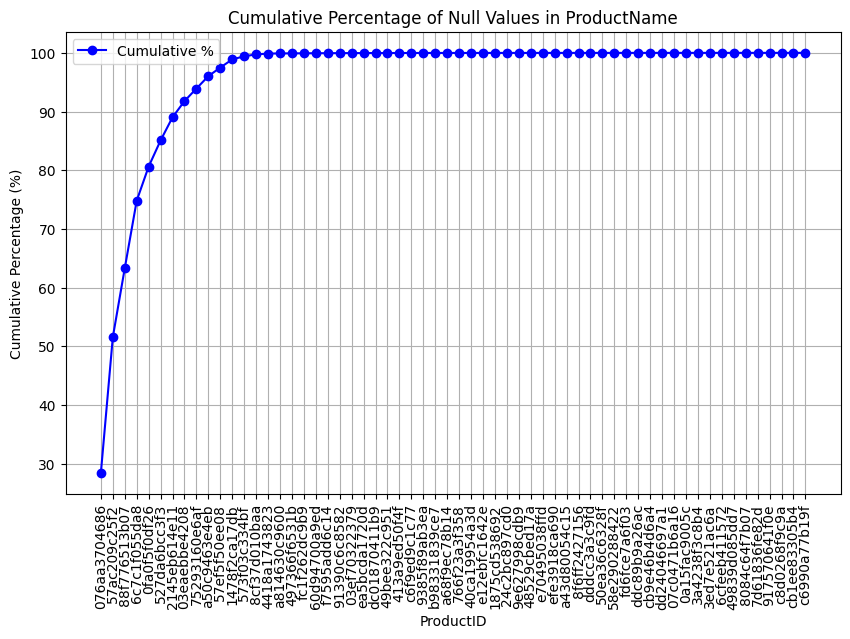

In [29]:
# Plot cumulative percentage
plt.figure(figsize=(10, 6))
plt.xlabel("ProductID")
plt.ylabel("Cumulative Percentage (%)")
plt.title("Cumulative Percentage of Null Values in ProductName")

# Plot as a line chart
plt.plot(quantity_productid_null_values["ProductID"], quantity_productid_null_values["cumulative_percentage"],
         marker="o", linestyle="-", color="b", label="Cumulative %")

plt.xticks(rotation=90)  # Rotate X-axis labels for better readability
plt.legend()
plt.grid()
plt.show()

### Checking the Stores associated in the null ProductName values

* There are **100** Stores that sells Products without a Name, that correspond to the **57%** of the total Stores in the dataset.

In [30]:
unique_store_id_null_values = null_values_product_name['StoreID'].unique().compute()
len(unique_store_id_null_values)

100

In [31]:
(len(unique_store_id_null_values)/df['StoreID'].nunique().compute())*100

57.14285714285714

### Same exercise of ProductID with StoreID

In [32]:
quantity_storeid_null_values = null_values_product_name.groupby('StoreID').size().reset_index()
quantity_storeid_null_values = quantity_storeid_null_values.rename(
    columns={0: 'Quantity'}).sort_values(by='Quantity', ascending = False).compute()
quantity_storeid_null_values['percentage'] = (quantity_storeid_null_values['Quantity']/quantity_storeid_null_values['Quantity'].sum())*100
# Compute cumulative sum of percentages
quantity_storeid_null_values["cumulative_percentage"] = quantity_storeid_null_values["percentage"].cumsum()
quantity_storeid_null_values.head(50)

,StoreID,Quantity,percentage,cumulative_percentage
75,b4ff1d2c0715,18664,5.145354,5.145354
46,75f1ac93df27,7066,1.947979,7.093333
48,77e97d07e6d6,6725,1.853971,8.947303
13,250e620ccc15,6579,1.813721,10.761024
65,a29ad3c8b8f9,6253,1.723848,12.484872
79,bdc01b106dff,6060,1.670641,14.155513
71,af21219873ae,5931,1.635078,15.790591
8,10538d18fa22,5915,1.630667,17.421258
83,d3915918d30b,5888,1.623224,19.044482
19,2f21775975b9,5881,1.621294,20.665775


### Histogram of the distribution of null values in ProductName by Store
It is possible to observe that there is no an specific Store that acumulate the Products without a name

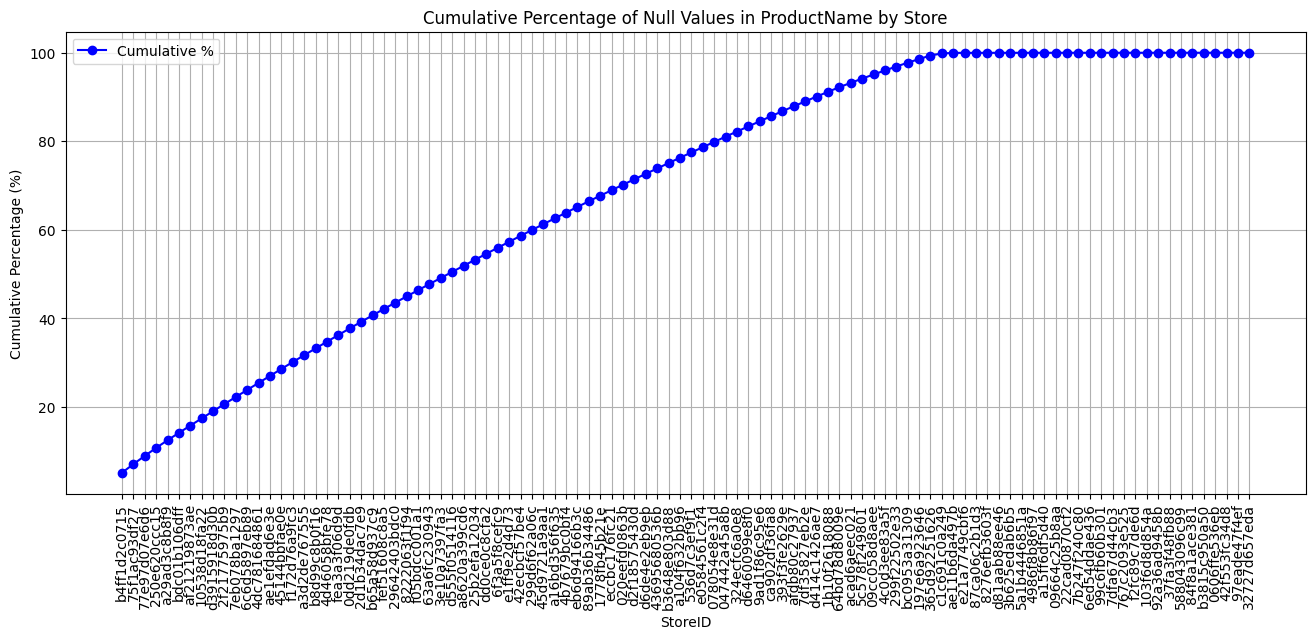

In [33]:
# Plot cumulative percentage
plt.figure(figsize=(16, 6))
plt.xlabel("StoreID")
plt.ylabel("Cumulative Percentage (%)")
plt.title("Cumulative Percentage of Null Values in ProductName by Store")

# Plot as a line chart
plt.plot(quantity_storeid_null_values["StoreID"], quantity_storeid_null_values["cumulative_percentage"],
         marker="o", linestyle="-", color="b", label="Cumulative %")

plt.xticks(rotation=90)  # Rotate X-axis labels for better readability
plt.legend()
plt.grid()
plt.show()

### Selecting non null values from **df**

Observe if is it possible to find the names of products in the non null values dataframe

In [34]:
non_null_values_df = df.dropna(subset=['ProductName'])

In [35]:
non_null_values_df.isnull().sum().compute()/non_null_values_df.shape[0].compute()

,0
Date,0.0
ProductID,0.0
StoreID,0.0
ProductName,0.0
Quantity,0.0
Price,0.0


### Selecting unique rows from the **non_null_values_df** with respect to the column **ProductID**

In [36]:
# Selecting unique rows from the non_null_values_df with respect to the column ProductID
unique_product_id_non_null = non_null_values_df.drop_duplicates(subset=['ProductID'])

### Check in the non values rows of **unique_product_id_non_null** if there are coincidence with the **unique_product_id** variable

In [37]:
# Check in the non null values rows of unique_product_id_non_null
# if there are coincidence with the unique_product_id variable
coincidence = unique_product_id_non_null[unique_product_id_non_null['ProductID'].isin(unique_product_id_null_values)]

In [38]:
coincidence.shape[0].compute()

0

### Null values from **ProductName** does not have an **ID** or **product name** in the non null values

### Checking the date of the Null values

The null product names are distributed in the whole period

In [39]:
# Group by the Date column of the Null values null_values_product_name and count
quantity_date_null_values = null_values_product_name.groupby('Date').size().reset_index()
quantity_date_null_values = quantity_date_null_values.rename(columns={0: 'Quantity'}).compute()
quantity_date_null_values.head()

,Date,Quantity
0,2022-08-01,369
1,2022-08-02,373
2,2022-08-03,358
3,2022-08-04,335
4,2022-08-05,392


In [40]:
quantity_date_null_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778 entries, 0 to 777
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      778 non-null    string
 1   Quantity  778 non-null    int64 
dtypes: int64(1), string(1)
memory usage: 19.9 KB


In [41]:
quantity_date_null_values.shape

(778, 2)

### Mean of the Quantity column in the quantity_date_null_values


In [42]:
mean_quantity_date_null_values = quantity_date_null_values['Quantity'].mean()

### Histogram of the dates with respect to the quantity of them in the null values dataset
* The mean is with respect to the quantity of dates.
* Next graph shows that it is possible that the null values in ProductName is given by a repetitive process in the construction of the database.
* It means that the 4 products that represents more than **90%** of the null values in ProductName are distributed from 2022 to 2024.

In [43]:
def plot_date_vs_column(df, column):
    mean_df = df[column].mean()
    # histogram of the quantity_date_null_values
    # putting in the x axis the index Date
    # Plot Date vs. Numeric Column
    plt.figure(figsize=(12, 6))
    plt.plot(df["Date"],
            df["Quantity"], marker="o",
            linestyle="-", color="b")  # Change "Quantity" to your numeric column

    # Plot a horizontal line for the mean
    plt.axhline(mean_df, color="r", linestyle="--", linewidth=2,
                label=f"Mean: {mean_df:.2f}")

    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))

    plt.xlabel("Date")
    plt.ylabel(column)
    title = f"Date vs. {column}"
    plt.title(title)
    plt.xticks(rotation=90)  # Rotate dates for better readability
    plt.grid()
    plt.show()

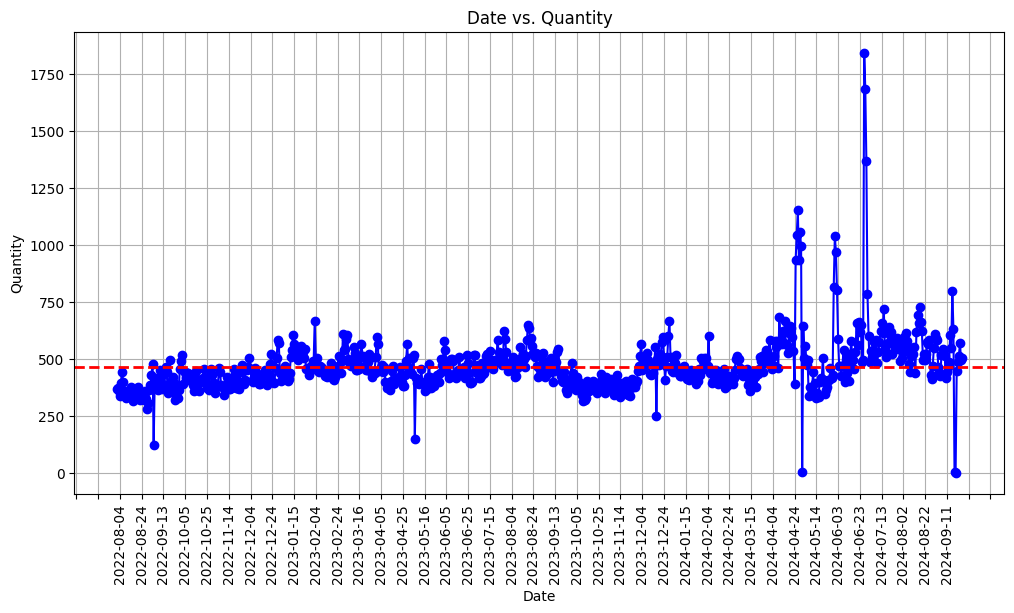

In [44]:
plot_date_vs_column(quantity_date_null_values, 'Quantity')

### Checking the Stores associated with Null ProductNames

Next plot shows the quantity of stores increases when increases the quantity of null ProductNames

In [45]:
store_null_values = null_values_product_name.groupby(
    ["Date", "StoreID"]
    ).size().reset_index().rename(columns={0: "Quantity"}).compute()


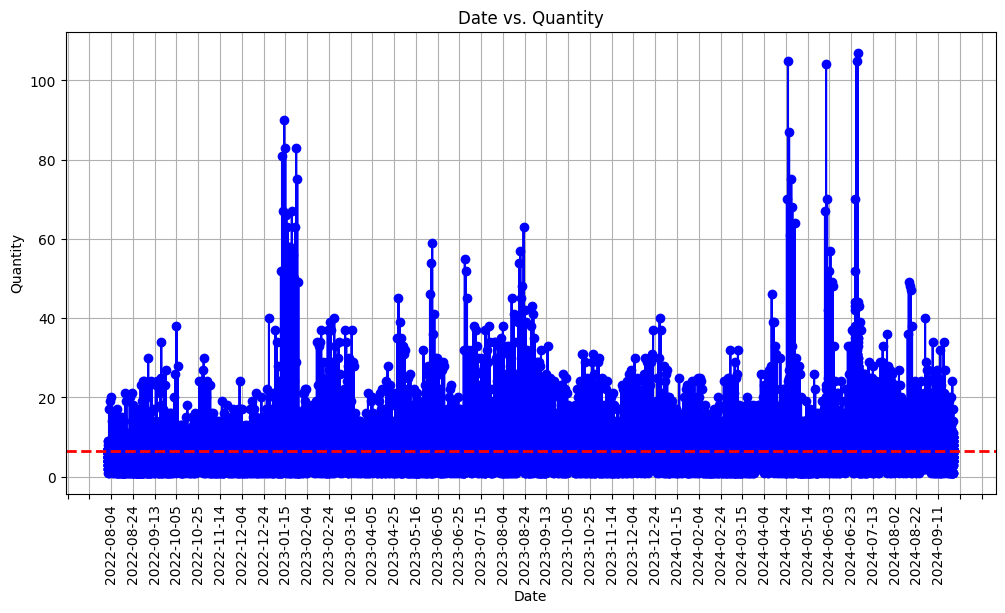

In [46]:
plot_date_vs_column(store_null_values, 'Quantity')

### If there is time create a graph show the relation of the 4 products with the rest of Stores.

In [47]:
# Group by Date, ProductID, and StoreID to get daily sales
df_grouped_null_values = null_values_product_name.groupby(["ProductID", "StoreID"]).agg({"Quantity": "sum", "Price": "mean"}).compute()
df_grouped_null_values

Quantity        Price
ProductID    StoreID                              
57ac209c25f2 b4ff1d2c0715  10315.3014  2390.386806
             eb6d94166b3c   1048.0590  2762.539361
             d555f0514116   1288.1430  2766.224692
076aa3704686 75f1ac93df27   4505.2686  2138.273502
             a29ad3c8b8f9   4499.7282  2180.673958
...                               ...          ...
4418a1743823 dd0ce0c8cfa2      1.8468  1543.924800
             42ecbcf57be4      1.8468  1543.924800
             5c578f249801      0.9234  1543.924800
             64bd78d8009e      0.9234  1543.924800
             c1c691c0a249      0.9234  1543.924800

[1213 rows x 2 columns]

### replacing null values of ProductName with the ProductID
ProductID could be used as a name for the ProductName. Doing this it is not necessary to remove data

In [48]:
# ProductID could be used as a name for the ProductName. Doing this it is not necessary to remove data
df['ProductName'] = df['ProductName'].fillna(df['ProductID'])

### Checking null values in **df**

In [49]:
df.isnull().sum().compute()/df.shape[0].compute()

,0
Date,0.0
ProductID,0.0
StoreID,0.0
ProductName,0.0
Quantity,0.0
Price,0.0


### Changing the data type of Date column to Date type

In [50]:
df['Date'] = dd.to_datetime(df['Date'], format = '%Y-%m-%d')

### Set index column Date

In [51]:
df = df.set_index('Date', sorted = True)

In [52]:
# Ensure each partition is sorted by the index
df = df.map_partitions(lambda pdf: pdf.sort_index())

### 1. Seasonality in overall sales:
#### Aggregate daily sales (Quantity) and compute the seasonal decomposition.

In [53]:
daily_sales = df['Quantity'].resample('D').sum().compute()

### Seasonal Daily Study
* It suggests that the sales increases at the end of the years 2023 and 2024
* It also suggests that the null values could have noise.

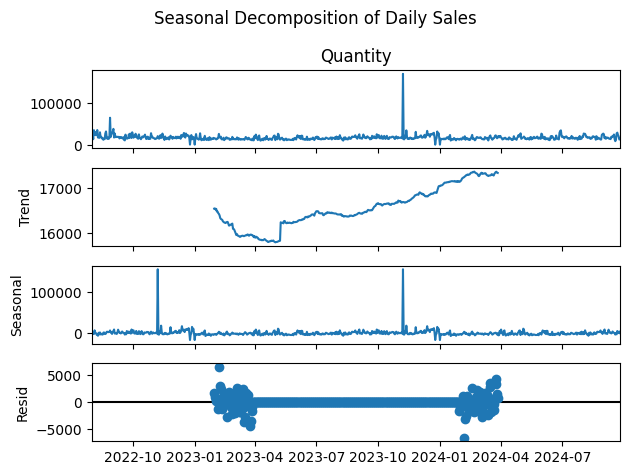

In [54]:
# Use a period of 365 to look for annual seasonality (adjust if needed)
decomp_result = sm.tsa.seasonal_decompose(daily_sales, model='additive', period=365)
decomp_result.plot()
plt.suptitle("Seasonal Decomposition of Daily Sales")
plt.tight_layout()
plt.show()

### 2. Which products have price fluctuations?

In [57]:
# Compute the mean and standard deviation of Price per ProductID.
price_stats = df.groupby('ProductID')['Price'].agg(['mean', 'std']).compute()
price_stats['cv'] = price_stats['std'] / price_stats['mean']  # coefficient of variation
print("Top products by price fluctuations (CV):")
top10_products_fluctuation = price_stats.sort_values(by='cv', ascending=False).reset_index().head(10)['ProductID']
price_stats.sort_values(by='cv', ascending=False).head(10)

Top products by price fluctuations (CV):


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mean,std,cv
ProductID,,,
93c66d7ed8c6,127.721095,49624.852976,388.540772
262b9ffa10b7,11.497202,27.721995,2.411195
23cd963d02eb,27.894204,55.803990,2.000559
f5c839fccf0d,10.292073,20.566280,1.998264
3967ee692a2f,276.084288,390.626194,1.414880
bdf65a9f1538,6.873138,6.489928,0.944245
740d550f4228,48.312288,41.616195,0.861400
2e86ec5da9dd,7.170841,5.253539,0.732625
110c9eaff5ce,1484.554324,939.892413,0.633114


### Next products indicates a high fluctuation in the price along time

In [58]:
df[df['ProductID'].isin(top10_products_fluctuation)]['ProductName'].unique().compute()

,ProductName
0,Ebiten maki and Pepper Black Coarse
1,Chicken milanese and Peppercorns White
2,French fries with sausages and Mace Whole
3,Lasagne and Korma Curry Powder
4,Katsu Curry and Peppercorns Green
5,Scotch eggs and Turmeric
6,California maki and Anise
7,Mushroom Risotto and Lime Leaves
8,Caprese Salad and Lime Leaves Ground
9,Salmon nigiri and Fenugreek Seed


### 3. Identify seasonality patterns (daily, weekly, monthly)

In [59]:
# Reset the index to work with Date as a column.
df = df.reset_index()

In [60]:
# Create a Month column with the Date Column
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Weekday'] = df['Date'].dt.weekday  # Monday=0, Sunday=6
df['week_of_year'] = df['Date'].dt.isocalendar().week

In [61]:
df.groupby(['Date', 'week_of_year']).head().compute()

,Date,ProductID,StoreID,ProductName,Quantity,Price,Month,Year,Weekday,week_of_year
0,2022-08-01,2e86ec5da9dd,4b429145d0d6,Ebiten maki and Pepper Black Coarse,0.9234,8.033580,8,2022,0,31
1,2022-08-01,2e86ec5da9dd,341e10db8b58,Ebiten maki and Pepper Black Coarse,0.9234,7.433370,8,2022,0,31
2,2022-08-01,2e86ec5da9dd,37fa3f48fb88,Ebiten maki and Pepper Black Coarse,0.9234,6.805458,8,2022,0,31
3,2022-08-01,e6dc17d84357,767c2093e525,Califlower penne and Pimento Ground,0.9234,9.003150,8,2022,0,31
4,2022-08-01,463bb3d2c83a,9961580664a2,Cheeseburger and Amchoor,0.9234,6.177546,8,2022,0,31
...,...,...,...,...,...,...,...,...,...,...
4973609,2024-09-25,93c66d7ed8c6,f2fc89c7de6d,Chicken milanese and Peppercorns White,0.9234,7.433370,9,2024,2,39
4973610,2024-09-25,463bb3d2c83a,a999d10ec22a,Cheeseburger and Amchoor,0.9234,4.303044,9,2024,2,39
4973611,2024-09-25,93c66d7ed8c6,5a1b4446851a,Chicken milanese and Peppercorns White,0.9234,7.433370,9,2024,2,39
4973612,2024-09-25,e03381b471a7,4c0d3ee83a5f,Ricotta stuffed Ravioli and Celery Salt,0.9234,2289.108600,9,2024,2,39


In [62]:
# Aggregate sales by month and weekday.
monthly_sales = df.groupby('Month')['Quantity'].sum().compute()
weekly_sales  = df.groupby('Weekday')['Quantity'].sum().compute()

### Quantity of sales by Month and Weekday
* It is possible to observe that the months August and September are the months with more quantity in sells.
* With respect to week day it is possible to observe that weekend are days with more quantity of sales

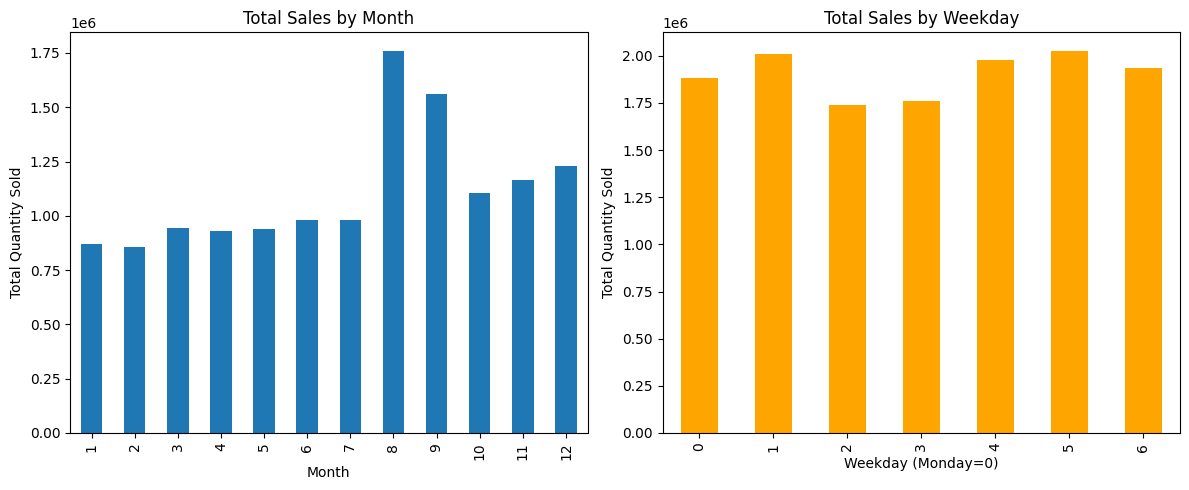

In [63]:
# Plot monthly sales
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
monthly_sales.plot(kind='bar')
plt.title("Total Sales by Month")
plt.xlabel("Month")
plt.ylabel("Total Quantity Sold")

# Plot weekday sales
plt.subplot(1, 2, 2)
weekly_sales.plot(kind='bar', color='orange')
plt.title("Total Sales by Weekday")
plt.xlabel("Weekday (Monday=0)")
plt.ylabel("Total Quantity Sold")
plt.tight_layout()
plt.show()

In [64]:
# Create a new column 'year_month' in YYYY-MM format
df['year_month'] = df['Date'].dt.strftime('%Y-%m')

In [65]:
# Group by year_month and sum Quantity, then compute the result
monthly_quantity = df.groupby('year_month')['Quantity'].sum().compute()

In [66]:
monthly_quantity.head()

,Quantity
year_month,
2022-08,686363.097188
2022-09,584276.643430
2022-10,570884.662800
2022-11,501572.412000
2022-12,571482.102600


In [67]:
week_quantity = df.groupby(['Year','week_of_year'])['Quantity'].sum().reset_index().compute()

In [68]:
week_quantity.head()

,Year,week_of_year,Quantity
0,2022,31,162400.082911
1,2022,32,161076.048277
2,2022,33,115617.067200
3,2022,34,175688.854200
4,2022,35,184797.271800


In [69]:
week_quantity['Year-Week'] = week_quantity['Year'].astype(str) + '-' + week_quantity['week_of_year'].astype(str)
week_quantity = week_quantity.set_index('Year-Week')
week_quantity = week_quantity.drop(columns=['Year', 'week_of_year'])
week_quantity.head()


,Quantity
Year-Week,
2022-31,162400.082911
2022-32,161076.048277
2022-33,115617.067200
2022-34,175688.854200
2022-35,184797.271800


### It is possible to observe that there is a increment in December of the quantity sales

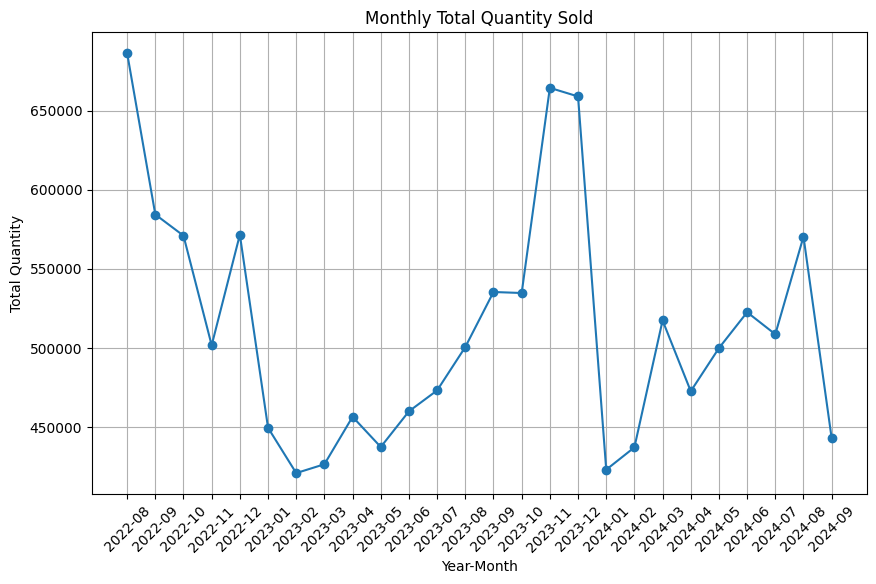

In [70]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(monthly_quantity.index, monthly_quantity.values, marker='o', linestyle='-')
plt.xlabel('Year-Month')
plt.ylabel('Total Quantity')
plt.title('Monthly Total Quantity Sold')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

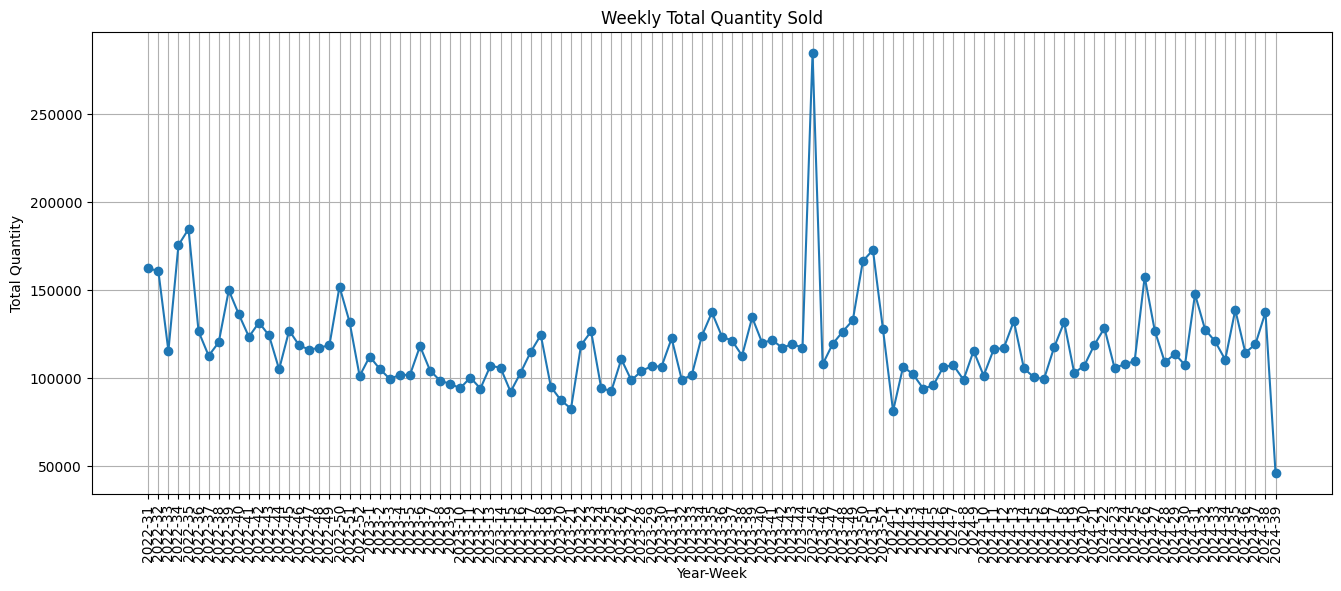

In [71]:
# Plotting
plt.figure(figsize=(16, 6))
plt.plot(week_quantity.index, week_quantity.values, marker='o', linestyle='-')
plt.xlabel('Year-Week')
plt.ylabel('Total Quantity')
plt.title('Weekly Total Quantity Sold')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

### 4. Detect products with high price-demand correlation.

In [72]:
# Define a function to compute correlation for each product group.
def price_demand_corr(pdf):
    return pdf['Price'].corr(pdf['Quantity'])

In [73]:
# Apply the function grouped by ProductID.
# (Note: We use .apply with meta to tell Dask the result is a float.)
correlations = df.groupby('ProductID').apply(price_demand_corr, meta=('corr', 'float64')).compute()
# Sort products by correlation (highest positive correlation first)
print("Products with high Price-Demand Correlation:")
print(correlations.sort_values(ascending=False).head(10))

/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1615: RuntimeWarning: Degrees of freedom <= 0 for slice
  return f(a, b)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Products with high Price-Demand Correlation:
ProductID
fea467897d62    1.000000
40c2c76c539d    1.000000
a13e9c584b18    1.000000
9385f89ab3ea    1.000000
3b15cb6c5ec4    1.000000
590cb546f4d3    1.000000
36aabf62886b    1.000000
adeba912ff56    0.790569
a79f43ae1f64    0.777620
577f60b90f4e    0.670438
Name: corr, dtype: float64


### Next product shows a high correlation between quantity and price
It means that when increase the price increase the sales quantity or when decrease the price decrease the sales quantity.

In [74]:
df[df['ProductID'].isin(['fea467897d62', 'a13e9c584b18', '40c2c76c539d',
                         '3b15cb6c5ec4', '9385f89ab3ea', 'a79f43ae1f64',
                         'adeba912ff56'])]['ProductName'].unique().compute()

,ProductName
0,Katsu Curry and Colombo Powder
1,Meatballs with sauce and Thai Stir Fry
2,9385f89ab3ea
3,Caesar Salad and Lime Leaves Ground
4,Pasta with Tomato and Basil and Dill Seed
5,Pasta and Beans and Vanilla Pods
6,Califlower penne and Mustard Seed Brown


### Saving preprocess dataset in .parquet format

In [75]:
df.compute()

,Date,ProductID,StoreID,ProductName,Quantity,Price,Month,Year,Weekday,week_of_year,year_month
0,2022-08-01,2e86ec5da9dd,4b429145d0d6,Ebiten maki and Pepper Black Coarse,0.9234,8.033580,8,2022,0,31,2022-08
1,2022-08-01,2e86ec5da9dd,341e10db8b58,Ebiten maki and Pepper Black Coarse,0.9234,7.433370,8,2022,0,31,2022-08
2,2022-08-01,2e86ec5da9dd,37fa3f48fb88,Ebiten maki and Pepper Black Coarse,0.9234,6.805458,8,2022,0,31,2022-08
3,2022-08-01,e6dc17d84357,767c2093e525,Califlower penne and Pimento Ground,0.9234,9.003150,8,2022,0,31,2022-08
4,2022-08-01,463bb3d2c83a,9961580664a2,Cheeseburger and Amchoor,0.9234,6.177546,8,2022,0,31,2022-08
...,...,...,...,...,...,...,...,...,...,...,...
4978863,2024-09-25,e03381b471a7,a8620a399cd6,Ricotta stuffed Ravioli and Celery Salt,0.9234,2327.891400,9,2024,2,39,2024-09
4978864,2024-09-25,08d0e7cf1a20,7df35827eb2e,Linguine with clams and Cinnamon Sticks,0.9234,13183.381800,9,2024,2,39,2024-09
4978865,2024-09-25,77ff83144155,b65a58d937c9,Pasta Carbonara and Pot Marjoram,0.9234,3871.816200,9,2024,2,39,2024-09
4978866,2024-09-25,cc2954a8b259,b4ff1d2c0715,Pizza and Ras-el-Hanout,0.9234,12221.199000,9,2024,2,39,2024-09


### Saving preprocess data

In [76]:
# Saving preprocess dataset in .parquet format
df.to_parquet('/content/drive/MyDrive/celes_test/data_challenge_preprocess.parquet')